# Uber Ride Price Prediction
# Using Linear Regression & Random Forest Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# Step 1: Load Dataset
df = pd.read_csv("uber.csv")
df.head() # Display first few rows

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [2]:
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [3]:
df.describe() # Get statistical summary

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [4]:
# Step 2: Handle Missing Values
df.isna().sum()
df.dropna(inplace=True)

In [5]:
# Step 3: Feature Transformation
# Drop unwanted columns
df.drop(["key", "Unnamed: 0"], axis=1, inplace=True)

# Convert 'key' to time (hour) and rename to 'time'
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['pickup_datetime'].dt.hour

df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,pickup_hour
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17


In [6]:
# other features that can be dded
# is_night, cylindrical time features like hour_sin, hour_cos, dow_sin and dow_cos

In [7]:
df.drop(columns=['pickup_datetime'], inplace=True)

In [8]:
df.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
year                   int32
month                  int32
day                    int32
day_of_week            int32
pickup_hour            int32
dtype: object

In [9]:
# Step 4: Feature Engineering — Calculate Distance

# Haversine formula — gives real distance in kilometers
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # distance in kilometers

df['distance_km'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

In [10]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,pickup_hour,distance_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,3,19,1.683323
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,4,20,2.457590
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,0,21,5.036377
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,4,8,1.661683
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,3,17,4.475450


<Axes: xlabel='passenger_count', ylabel='count'>

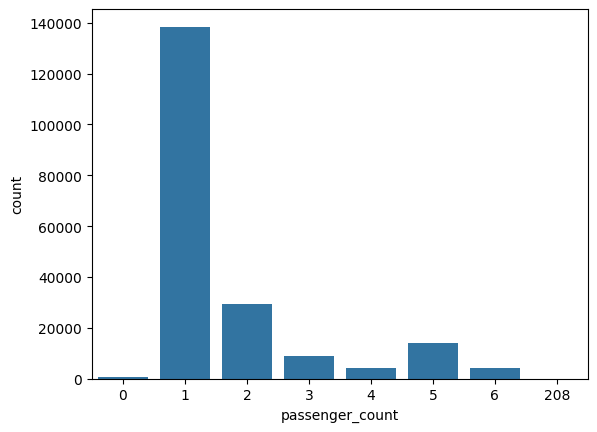

In [11]:
sns.countplot(df, x="passenger_count")

<Axes: xlabel='fare_amount', ylabel='Count'>

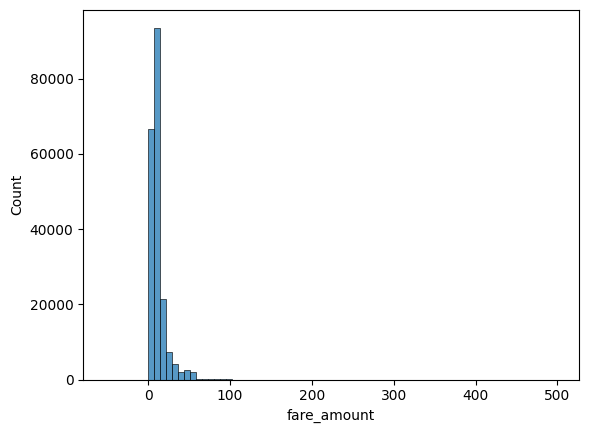

In [12]:
sns.histplot(data=df, x = 'fare_amount', bins=75, kde=False)

In [13]:
def remove_outliers(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    df_new = df.loc[(df[feature] > lower) & (df[feature] < upper)].copy()
    return df_new

X = df.drop(df.loc[df['passenger_count']>6].index, axis='index')
X.drop(X.loc[X['fare_amount']>60].index, axis='index', inplace = True)

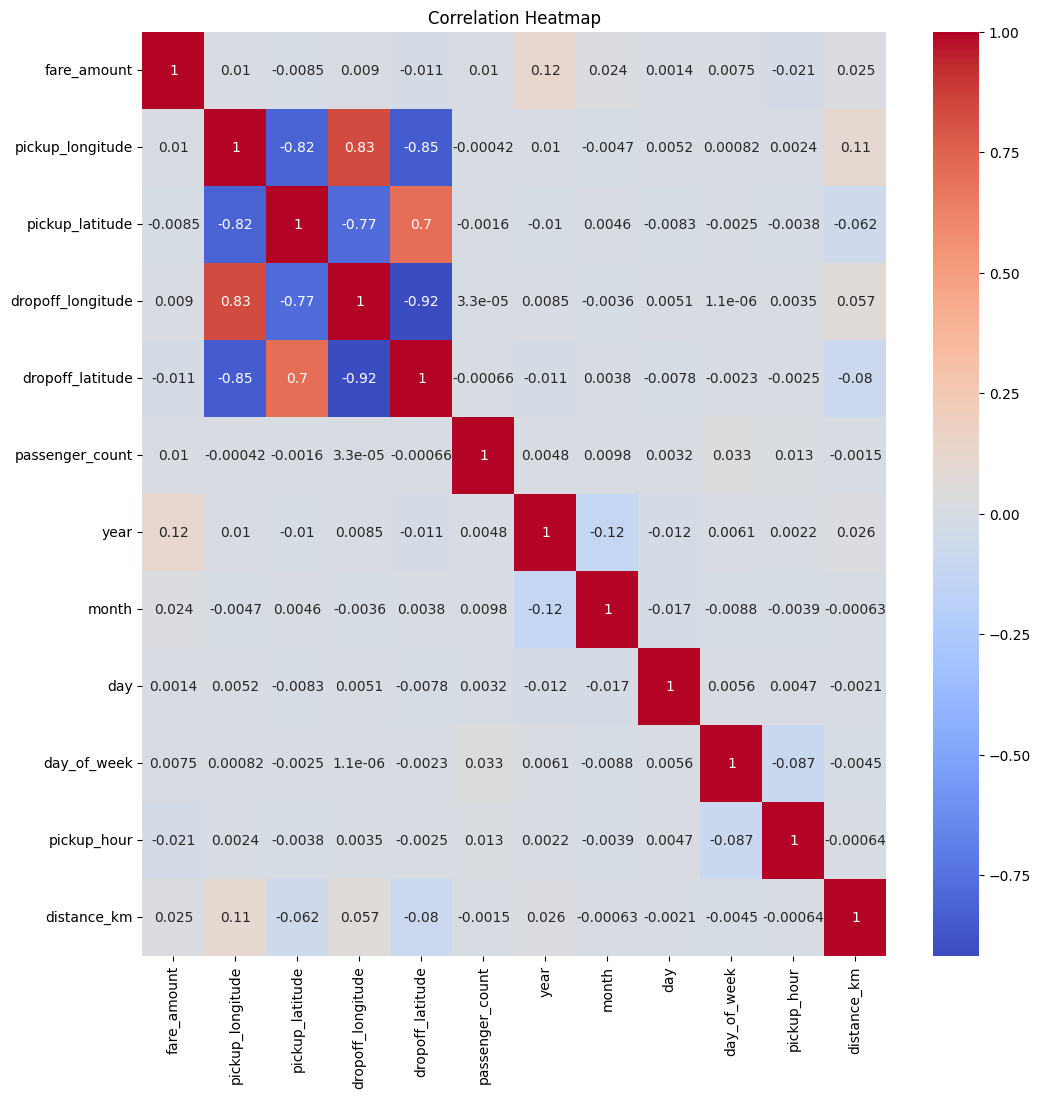

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('fare_amount', axis=1)
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("R2 score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))


R2 score: 0.016851768590576577
RMSE: 10.112909909669408


In [17]:
from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor() 
model.fit(X_train_scaled, y_train) 
y_pred = model.predict(X_test_scaled) 
print("R2 score:", r2_score(y_test, y_pred)) 
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2 score: 0.7337010817677819
RMSE: 5.263217753696844


In [19]:
# Faster model
model = RandomForestRegressor(
    n_estimators=30,      # fewer trees
    max_depth=15,         # limit tree depth
    random_state=42,
    n_jobs=-1             # use all CPU cores
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("R2 score:", r2_score(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))


R2 score: 0.7270857090943061
RMSE: 5.328190895032335
